In [ ]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt

import LE as le
import LP as lp
import iterative as iterative
import logger_creator

import graph_tools
import networkx as nx
import numpy as np
import pandas as pd

In [44]:
import importlib
importlib.reload(graph_tools)

<module 'graph_tools' from '/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis/graph_tools.py'>

# Create Graph

In [54]:
epinions_graph = nx.read_edgelist(
    "../datasets/soc-Epinions1_clean.txt",
    comments="#",
    delimiter="\t",
    create_using=nx.DiGraph,
    nodetype=str,
)

print(len(list(epinions_graph.nodes())))
print(len(list(epinions_graph.edges())))

75879
508837


In [55]:
epinions_graph_prepared = None
epinions_graph_prepared = graph_tools.prepare_graph(epinions_graph.nodes(), epinions_graph.edges(), sink_frac=0.0)
nodes = epinions_graph_prepared.nodes()
delegations_orig = graph_tools.nx_graph_to_dict(epinions_graph_prepared)
delegations = graph_tools.invert_graph(delegations_orig)

# Explore Graph

count    75139.000000
mean         6.756345
std         26.077540
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       1794.000000
dtype: float64

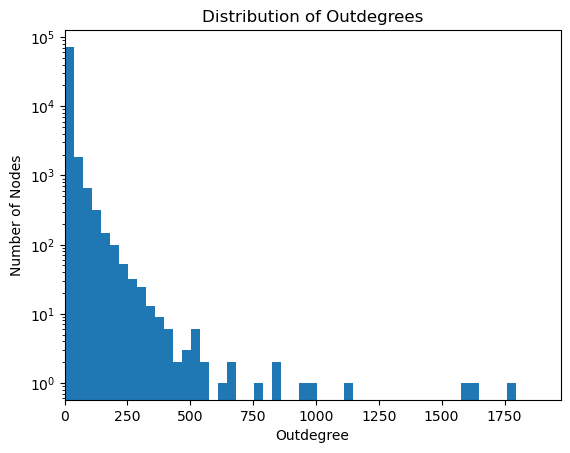

In [96]:
# Distribution of the outdegree
outdegrees = pd.Series([len(delegations_orig[node]) for node in nodes])

display(outdegrees.describe())

plt.figure()
plt.hist(outdegrees, bins=50)
plt.xlabel('Outdegree')
plt.ylabel('Number of Nodes')
plt.title('Distribution of Outdegrees')
plt.yscale('log')
plt.xlim(0, outdegrees.max() * 1.1) 
plt.show()

In [32]:
# Number of sinks vs total number of nodes
sinks = [node for node in nodes if len(delegations_orig[node]) == 0]
print("Number of sinks:", len(sinks))
print("Total number of nodes:", len(nodes))
print("Fraction of sinks:", len(sinks) / len(nodes))

Number of sinks: 15539
Total number of nodes: 75139
Fraction of sinks: 0.20680339104858994


2025-06-24 11:22:59,391 - INFO - Initially 75879 nodes, after collapsing terminal SCCs 75139 nodes remain. In total 330 terminal SCCs were collapsed.

In [92]:
removed_nodes = 75879 - 75139
amount_of_clos_deg_cycles = 330
print("Amount of removed edges", removed_nodes)
print("Fraction of removed nodes:", removed_nodes / len(nodes))
print("Average number of nodes per closed delegation cycle:", removed_nodes / amount_of_clos_deg_cycles)

Amount of removed edges 740
Fraction of removed nodes: 0.009848414272215495
Average number of nodes per closed delegation cycle: 2.242424242424242


# Get and Explore Results

In [45]:
powers, sinks = le.resolve_delegations(delegations, nodes)

In [ ]:
powers_df = pd.DataFrame.from_dict(powers, orient="index", columns=["power"])

In [91]:
lost_power = powers_df.loc["lost"] + removed_nodes
print("Total lost power:", lost_power)
print("Fraction of lost power:", lost_power / len(nodes))

Total lost power: power    2777.056087
Name: lost, dtype: float64
Fraction of lost power: power    0.036959
Name: lost, dtype: float64


## With "lost" power

In [ ]:
powers_df.describe()

,power
count,75139.000000
mean,1.000000
std,15.146525
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2037.056087


In [41]:
display(powers_df.sort_values(by="power", ascending=False))

,power
lost,2037.056087
5250,1755.090454
548,1705.662439
4055,1578.994995
5273,1036.967093
...,...
1808,0.000000
8883,0.000000
9998,0.000000
12390,0.000000


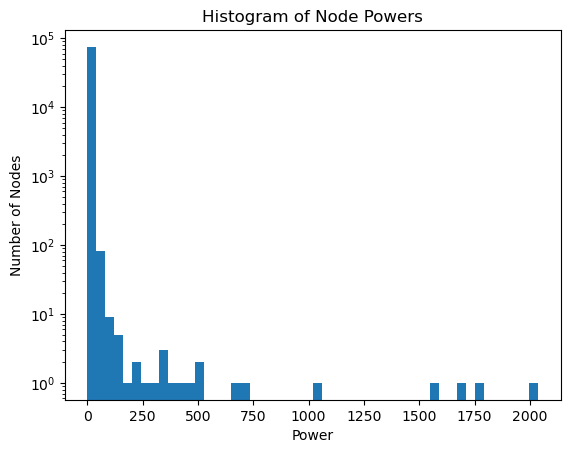

In [95]:
plt.hist(powers_df['power'], bins=50)
plt.xlabel('Power')
plt.ylabel('Number of Nodes')
plt.title('Histogram of Node Powers')
plt.yscale('log')
plt.show()

## Without "lost" power

In [43]:
powers_df_clean = powers_df.drop(index="lost")
powers_df_clean.describe()

,power
count,75138.000000
mean,0.972902
std,13.200253
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1755.090454


# Benchmark

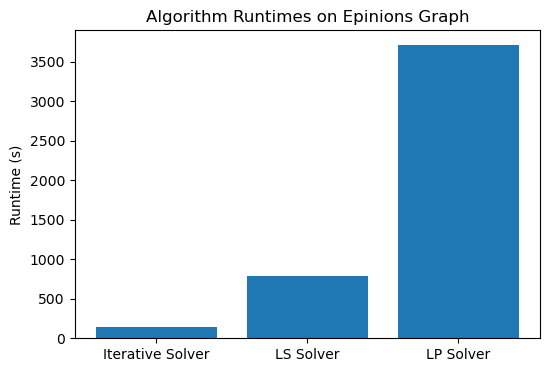

In [ ]:
logger, handler = logger_creator.create_logger("benchmarking")

# Verify the solutions are equal
powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
powers_iter = iterative.iterate_delegations(delegations, nodes)

if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-6 for k in powers_le):
    logger.error("Powers do not match")
    logger.error(f"LE: {powers_le}")
    logger.error(f"LP: {powers_lp}")
    print("Mismatching powers in LE and LP. Check the log file for details.")
    
for node in sinks_le:
    if (powers_lp[node] - powers_iter[node] < 0.01):
        continue
    else: 
        logger.error("Powers do not match")
        logger.error(f"LP: {powers_lp}")
        logger.error(f"Iterative: {powers_iter}")
        print("Mismatching powers in LP and Iterative. Check the log file for details.")
        break

n = 2

# LE
le_model = le.set_up(delegations, nodes)
start_time = time.time()
for _ in range(n):
    le.solve(*le_model)
end_time = time.time()
        
time_le = (end_time - start_time) / n

# LP
lp_model = lp.set_up(delegations, nodes)
start_time = time.time()
for _ in range(n):
    lp.solve(*lp_model)
end_time = time.time()

time_lp = (end_time - start_time) / n

# Iterative
start_time = time.time()
for _ in range(n):
    p = iterative.iterate_delegations(delegations, nodes)
end_time = time.time()

time_iterative = (end_time - start_time) / n


logger.removeHandler(handler)
handler.close()

plt.figure(figsize=(6,4))
plt.bar(["Iterative Solver", "LS Solver", "LP Solver"], [time_iterative, time_le, time_lp])
plt.ylabel("Runtime (s)")
plt.title("Algorithm Runtimes on Epinions Graph")
plt.show()

In [58]:
print("Time LE:", time_le)
print("Time LP:", time_lp)
print("Time Iterative:", time_iterative)

Time LE: 783.750997543335
Time LP: 3711.565323472023
Time Iterative: 143.32935547828674
